<a href="https://colab.research.google.com/github/ounospanas/AIDL_B02/blob/main/AIDL_B02_REINFORCE_Pong_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install "gymnasium[atari,accept-rom-license,other]" ale-py

In [ ]:
import numpy as np
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from matplotlib import pyplot as plt
from collections import deque
%matplotlib inline

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
class PolicyGradientNet(nn.Module):
    def __init__(self):
        super(PolicyGradientNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Pong has only 2 relevant actions (UP/DOWN), not 6 so remove the rest
        self.head = nn.Linear(1568, 2)  # could be 6 but is more challenging

        # Store episode data
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        # Return logits
        return self.head(x)

In [ ]:
def prepro(I):
    """Preprocess 210x160x3 uint8 frame into 80x80 float array"""
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float32)

In [ ]:
def select_action(model, state):
    """Select action using the policy network"""
    state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
    state = state.to(device)

    # Get logits from model
    logits = model(state)

    # Create categorical distribution
    m = Categorical(logits=logits)

    # Sample action
    action = m.sample()

    # Save the log probability of the sampled action
    model.saved_log_probs.append(m.log_prob(action))

    # Map to Pong actions: our network outputs 0/1, map to 2/3 (UP/DOWN)
    pong_action = action.item() + 2

    return pong_action

In [ ]:
def finish_episode(model, optimizer, gamma=0.99):
    """Calculate loss and perform backpropagation"""
    R = 0
    policy_loss = []
    returns = []

    # Calculate discounted returns
    for r in model.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)

    # Normalize returns
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # Calculate loss using saved log probabilities
    for log_prob, R in zip(model.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)

    # Backpropagation
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()

    # Clear episode data
    del model.rewards[:]
    del model.saved_log_probs[:]

In [ ]:
# Initialize environment and model
gym.register_envs(ale_py)
#env = gym.make('ALE/Pong-v5', render_mode=None)
env = gym.make('PongNoFrameskip-v4', render_mode=None)

model = PolicyGradientNet().to(device)

# FIX: Use Adam optimizer with higher learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Model initialized successfully!")

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


Model initialized successfully!


In [ ]:
# Training parameters
num_episodes = 2000
gamma = 0.99
running_reward = None
reward_history = []
save_every = 100

In [ ]:
# Main training loop
for episode in range(num_episodes):
    # Reset environment
    observation, info = env.reset()
    prev_x = None
    ep_reward = 0

    while True:
        # Preprocess observation
        cur_x = prepro(observation)

        # Compute difference frame
        if prev_x is not None:
            x = cur_x - prev_x
        else:
            x = np.zeros_like(cur_x)
        prev_x = cur_x

        # Select and take action
        action = select_action(model, x)

        # Make an environment step
        observation, reward, terminated, truncated, info = env.step(action)

        # Store reward
        model.rewards.append(reward)
        ep_reward += reward

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Perform REINFORCE update
    finish_episode(model, optimizer, gamma)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode}, Reward: {ep_reward:.2f}')

    if episode % 100 == 0 and episode != 0:
        print(f'Episode {episode}, Average: {np.mean(reward_history[-100:]):.2f}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'reward_history': reward_history
        }, f'pong_checkpoint_{episode}.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved
    if np.mean(reward_history[-100:]) > 20:
        print(f"Solved! Running reward: {running_reward:.2f}")
        torch.save(model.state_dict(), 'pong_solved.pt')
        break

env.close()
print("Training complete!")

Episode 0, Reward: 12.00
Episode 1, Reward: 11.00
Episode 2, Reward: 12.00
Episode 3, Reward: 8.00
Episode 4, Reward: 18.00
Episode 5, Reward: 15.00
Episode 6, Reward: 16.00
Episode 7, Reward: 15.00
Episode 8, Reward: 17.00
Episode 9, Reward: 14.00
Episode 10, Reward: 15.00
Episode 11, Reward: 20.00
Episode 12, Reward: 18.00
Episode 13, Reward: 14.00
Episode 14, Reward: 17.00
Episode 15, Reward: 13.00
Episode 16, Reward: 17.00
Episode 17, Reward: 14.00
Episode 18, Reward: 13.00
Episode 19, Reward: 19.00
Episode 20, Reward: 14.00
Episode 21, Reward: 15.00
Episode 22, Reward: 18.00
Episode 23, Reward: 14.00
Episode 24, Reward: 18.00
Episode 25, Reward: 17.00
Episode 26, Reward: 17.00
Episode 27, Reward: 18.00
Episode 28, Reward: 17.00
Episode 29, Reward: 19.00
Episode 30, Reward: 2.00
Episode 31, Reward: 20.00
Episode 32, Reward: 15.00
Episode 33, Reward: 17.00
Episode 34, Reward: 12.00
Episode 35, Reward: 18.00
Episode 36, Reward: 10.00
Episode 37, Reward: 16.00
Episode 38, Reward: 10.0

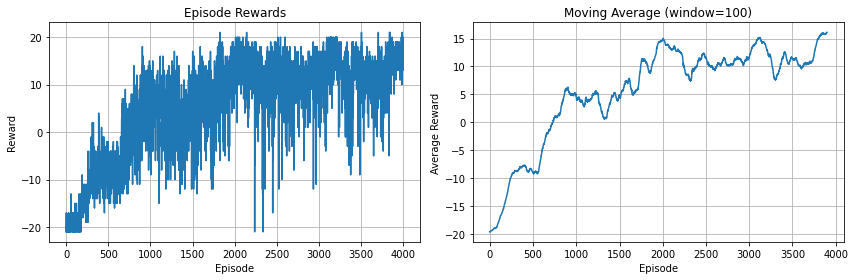

In [ ]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(reward_history)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
# Plot moving average
window = 100
if len(reward_history) >= window:
    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg)
    plt.title(f'Moving Average (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
np.mean(reward_history[-100:])

16.1

## Test the Trained Model

In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [ ]:
# load the weights from file
model = PolicyGradientNet().to(device)
model_info = torch.load('pong_checkpoint_1900.pt')
best_model_state = model_info['model_state_dict']
best_model = model.load_state_dict(best_model_state)

In [ ]:
import imageio
import numpy as np
import os


# Without RecordVideo wrapper
env = gym.make('PongNoFrameskip-v4', render_mode='rgb_array')
frames = []

for _ in range(1):
    state, info = env.reset()
    frames.append(env.render())  # Capture initial frame
    reward_sum = 0
    prev_x = None

    for t in range(10000):
        cur_x = prepro(state)
        x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
        prev_x = cur_x

        with torch.no_grad():
            action = select_action(model, x)

        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())  # Capture frame
        reward_sum += reward

        done = terminated or truncated
        if done:
            break

print(reward_sum)
env.close()

# Save video manually
video_path = 'episode.mp4'
imageio.mimsave(video_path, frames, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


8.0


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(video_path)
HTML(html)